# Alexa, what should I watch next?

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. 

Recommender Systems are a type of information filtering system as they improve the quality of search results and provides items that are more relevant to the search item or are related to the search history of the user.

Almost every major tech company has applied recommender systems in some form: Amazon uses it to suggest products to customers, YouTube uses it to decide which video to play next on autoplay and Facebook uses it to recommend pages to like and people to follow. Furthermore, companies like Netflix and Spotify depend on the effectiveness of their recommendation engines for the success of their business.

### Problem statement 
Construct a recommendation algorithm capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

##### Note to reader: This notebook was designed to be viewed in light mode
![Build-a-Recommendation-Engine-With-Collaborative-Filtering_Watermarked.451abc4ecb9f.jp](https://files.realpython.com/media/Build-a-Recommendation-Engine-With-Collaborative-Filtering_Watermarked.451abc4ecb9f.jpg)



# Table of contents 
* [Import libraries and datasets](#section-one)
* [First glance at the raw data](#section-two)
* [Preparing data for better visualization](#section-three)
* [Exploratory data analysis](#section-four)
  - [MovieLens rating distribution](#movielens)
  - [Distribution of average ratings](#subsection-one)
  - [Greatest hits: most popular movies](#subsection-two)
  - [Rating distribution: Shawshank Redemption](#rating)
  - [Movie genres](#subsection-three)
  - [Trends in genre popularity](#subsection-four)
  - [Plot keywords](#subsection-five)
  - [Directors](#subsection-six)
  - [Actors](#subsection-seven)
* [Memory handling](#section-fours)
* [Building the models](#section-five)
  - [Content based](#subsection-1)
    - [Creating the corpus for each movie](#corpus)
    - [Count matrix](#count)
    - [Cosine similarity matrix](#sim)
    - [Top-N recommendations](#top)
  - [Collaborative based](#subsection-2)
    - [Item-User based](#user)
    - [Item-Item based](#item)
    - [Singular value decomposition](#svd)
* [Submission](#section-six)
* [Conclusion](#section-seven)
* [References](#section-eight)

![popcorn.gif?w=371](https://watchaholichome.files.wordpress.com/2018/11/popcorn.gif?w=371)

#### "You don't have to be great to start but you have to start to be great..."

<a id="section-one"></a>
# Import libraries and datasets

In [ ]:
# Data manipulation
import numpy as np 
import pandas as pd   
import re

# Ignore warnings 
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Data visualization
import matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS 

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
sns.set(style="whitegrid")
sns.set_style("dark")

# Building recommender systems
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVD
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

We won't be making use of all the data available to us in an attempt to conserve RAM... Here we will import the dataframes we are interested in working with

In [ ]:
movies = pd.read_csv('movies.csv')
imdb_data = pd.read_csv('imdb_data.csv')
tags = pd.read_csv('tags.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

<a id="section-one"></a>
# First glance at the raw data

First look at the raw data available for this project

In [ ]:
# Display the first 5 entries in each dataframe 
display(movies.head())
display(imdb_data.head())
display(tags.head())
display(train.head())

# Count the number of unique entries for features of interest
unique_movies = len(movies['movieId'].unique().tolist())
unique_tags = len(tags['tag'].unique().tolist())
unique_users = len(train['userId'].unique().tolist())
unique_directors = len(imdb_data['director'].unique().tolist())
unique_actors = len(imdb_data['title_cast'].unique().tolist())

# Create a dataframe to store the number of unique entries for features of interest
unique = pd.DataFrame({"movies": [unique_movies],
                       "tags" : [unique_tags],
                       "users": [unique_users],
                       "directors" : [unique_directors],
                       "actors" : [unique_actors]}, index=['unique_entries'])

print('number of unique entries for features of interest')
display(unique.transpose())

# Determine and display the min and max ratings received
min_rating = train.rating.min()
max_rating = train.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


number of unique entries for features of interest


,unique_entries
movies,62423
tags,73051
users,162541
directors,11787
actors,17144


Lowest rating: 0.5
Highest rating: 5.0


**Observations:**

* There are a few tables with more information about the movies, these are all related by the movieId key
* Available information about each movie: Title, cast, runtime, budget, director, genre, plot keywords, tags and ratings
* There are just more than 60000 unique movies and 160000 unique users in the dataset
* There are more unique tags than unique movies in the dataset
* Movies are rated between 0 and 5 with the lowest rating being 0.5 and the highest 5.
* We are also given the timestamp for each rating which isn't particularly useful for our model development since the time a rating is done has nothing to do with a user's preferences or the quality of a film. The timestamps could, however, provide some meaningful insights in our EDA

<a id="section-three"></a>
# Preparing the data for better visualization
We start by selecting the movie features we want to investigate and create a new dataframe containing these features.

In [ ]:
df = imdb_data[['movieId','title_cast','director', 'plot_keywords']]
df = df.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995)
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry,Comedy|Romance,Grumpier Old Men (1995)
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...,Comedy|Drama|Romance,Waiting to Exhale (1995)
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Comedy,Father of the Bride Part II (1995)


The data is then formatted to make our lives easier when we start with the EDA

**Plan of action:**
- Convert data types to strings
- Remove the pipes between words
- Limit the number of keywords and cast members per movie
- Remove spaces between the names and surnames of actors/directors. This is so that names don't get confused or misinterpreted later on.

In [ ]:
# Convert data types to strings for string handling
df['title_cast'] = df.title_cast.astype(str)
df['plot_keywords'] = df.plot_keywords.astype(str)
df['genres'] = df.genres.astype(str)
df['director'] = df.director.astype(str)

# Removing spaces between names
df['director'] = df['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df['title_cast'] = df['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df['title_cast'] = df['title_cast'].map(lambda x: x.split('|')[:3])

# Discarding the pipes between the plot keywords' and getting only the first five words
df['plot_keywords'] = df['plot_keywords'].map(lambda x: x.split('|')[:5])
df['plot_keywords'] = df['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres 
df['genres'] = df['genres'].map(lambda x: x.lower().split('|'))
df['genres'] = df['genres'].apply(lambda x: " ".join(x))

df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,"[tomhanks, timallen, donrickles]",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995)
1,2,"[robinwilliams, jonathanhyde, kirstendunst]",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995)
2,3,"[waltermatthau, jacklemmon, sophialoren]",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995)
3,4,"[whitneyhouston, angelabassett, lorettadevine]",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995)
4,5,"[stevemartin, dianekeaton, martinshort]",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995)


<a id="section-four"></a>
# Exploratory data analysis 

We can now start to dive a little deeper into the movielens dataset.. Let's see what we uncover


![images?q=tbn%3AANd9GcTOBWDHACVbuMVwIT86dokU_IpFkHZI45hRsQ&usqp=CAU](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTOBWDHACVbuMVwIT86dokU_IpFkHZI45hRsQ&usqp=CAU)

<a id="movielens"></a>
## MovieLens rating distribution

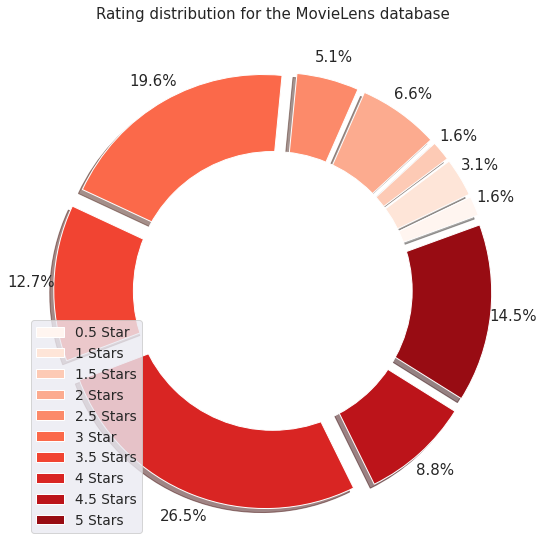

In [ ]:
# Merge train with movies to join movie titles and ratings 
ratings = train.merge(movies, on='movieId', how='inner')
ratings.drop('timestamp', axis=1, inplace=True)

# Count how many ratings are in each category (1 star, 2 star, ect)
grouped = pd.DataFrame(ratings.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Creating plots 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create colour palette
labels = ['0.5 Star', '1 Stars', '1.5 Stars', '2 Stars', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
theme = plt.get_cmap('Reds')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 shadow=True,
                 startangle=20,
                 pctdistance=1.115,
                 explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display donut plot with legend
plt.legend(pie[0], labels, loc="lower left")
ax.set_title('Rating distribution for the MovieLens database\n', fontsize=15)
plt.tight_layout()
plt.show()

**Observations:**
* 4 Star ratings make up the largest portion of ratings in the MovieLens dataset, accounting for 26.5% of the overall ratings.
* 5 star ratings make up 14.5%  of the overall ratings (3rd largest portion)
* 0.5 star ratings account for the smallest portion of the ratings at a mere 1.6%
* Ratings between 2 and 0.5 stars account for 12.9%

<a id="subsection-one"></a>
## Distribution of average ratings

Let's take a look at the average rating of each movie.

These stats could be misleading, though: A movie can make it to the top of the list even if only a single user has given it five stars.  Normally, a movie that's really a good one gets a higher rating by a large number of users. Keeping  this in mind we will record the number of ratings each film has received.

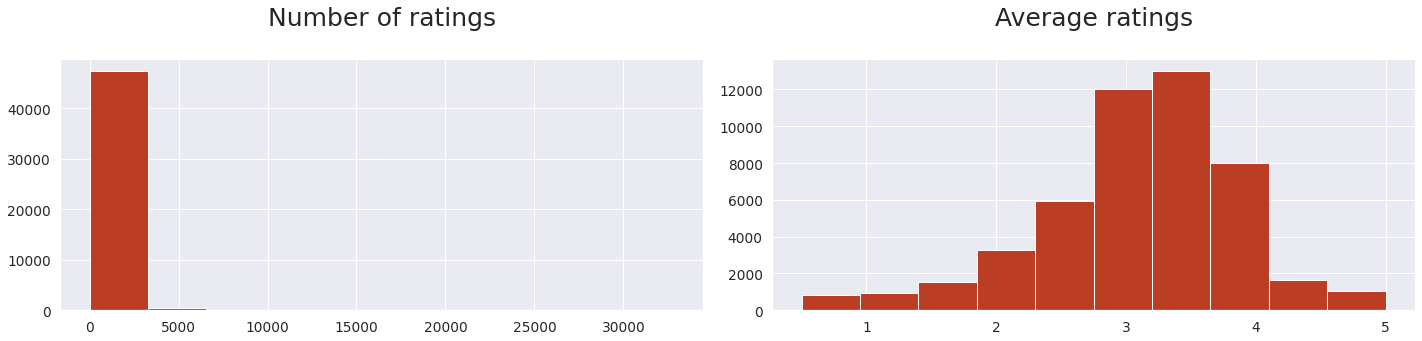

In [ ]:
# Determine the average rating and number of ratings for each movie
ratings_mean_count = pd.DataFrame(ratings.groupby(['title'])[['rating']].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count())
ratings_mean_count['popularity'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count()*ratings.groupby(['title'])['rating'].mean())

# Create a plot of the number of ratings 
f, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].hist(ratings_mean_count['rating_counts'], bins=10, color='#bb3d23')
axarr[0].set_title('Number of ratings\n', fontsize=25)

# Create a plot showing the average ratings distribution 
axarr[1].hist(ratings_mean_count['rating'], bins=10, color='#bb3d23')
axarr[1].set_title('Average ratings\n', fontsize=25)

# Display both plots
plt.tight_layout()
plt.show()

**Observations:**
* Most of the movies have received less than 2500 ratings. While the number of movies having more than 5000 ratings is very low.
* The ratings follow a normal distribution that is slightly skewed to the right. It seems like users are generally generous with their ratings.
* The mean rating is around 3.

## Release year

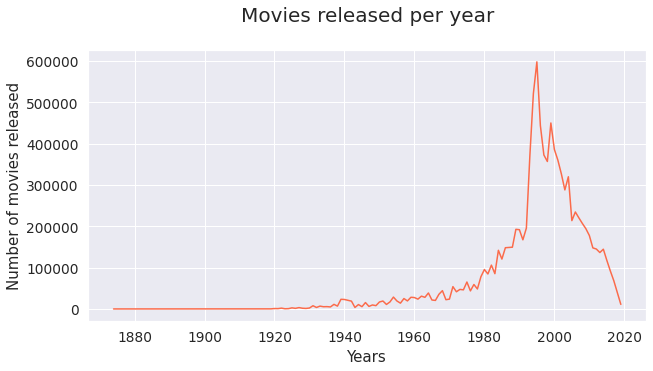

In [ ]:
# Extract the release year fron the movie titles
ratings['release_year'] = ratings.title.map(lambda x: re.findall('\d\d\d\d', x))
ratings.release_year = ratings.release_year.apply(lambda x: np.nan if not x else int(x[-1]))
years =  pd.DataFrame(ratings.groupby(['release_year'])['title'].count())
years.rename(columns={'title':'movies released'}, inplace=True)

# Plot the number of movies released per year
plt.figure(figsize=(10,5))
plot = sns.lineplot(data=years, dashes=False, legend=False, palette='Reds_r')

# Add figure labels
plt.xlabel('Years', fontsize=15)
plt.ylabel('Number of movies released', fontsize=15)
plt.title('Movies released per year\n', fontsize=20)

plt.show() 

**Observations:**
* This dataset contains movie ratings and movie specific data dating back 50 years. 
* There was a huge spike in movie production between 1990 and 2000 which has slowed down significantly in the last few years.

<a id="subsection-two"></a>
## Greatest hits: most popular movies
Popularity will be determined as the product of the average rating and the number of ratings a film has received.

In [ ]:
# Extract and display the 10 most popular films in the dataset 
ratings_mean_count = ratings_mean_count.sort_values(by='popularity', ascending=False).head(15)
ratings_mean_count.head(15)

,rating,rating_counts,popularity
title,,,
"Shawshank Redemption, The (1994)",4.417624,32831,145035.0
Pulp Fiction (1994),4.195097,31697,132972.0
Forrest Gump (1994),4.047216,32383,131061.0
"Silence of the Lambs, The (1991)",4.144172,29444,122021.0
"Matrix, The (1999)",4.154253,29014,120531.5
Star Wars: Episode IV - A New Hope (1977),4.111811,27560,113321.5
Schindler's List (1993),4.247625,24004,101960.0
Fight Club (1999),4.227906,23536,99508.0
Star Wars: Episode V - The Empire Strikes Back (1980),4.146236,22956,95181.0


**And the most popular movie is... The Shawshank redemption!!**

![13-Best-Shawshank.jpg](https://traditiononline.org/wp-content/uploads/2019/11/13-Best-Shawshank.jpg)

**Observations:**
* We see some really good movies like the Martrix, Star Wars and the Lord of the Rings in the top 15. 
* The above list supports our point that good movies normally receive both more and higher ratings
* An interesting thing to note is that all the movies in the top 10 are older, with none of the movies more recent than 1999.
* This just could be because these movies have been around longer and have been rated more as a result

<a id="rating"></a>
## Rating distribution: Shawshank Redemption
Let's take a closer look at how the ratings for the most popular movie are distributed

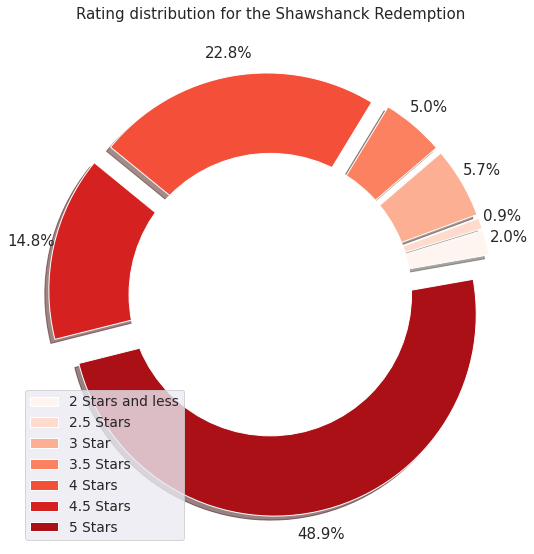

In [ ]:
# Extract shawshank redemption ratings
top = ratings[ratings['title']=='Shawshank Redemption, The (1994)']

# Group all 2 star and lower ratings together
top.rating[top.rating == 0.5] = 2 
top.rating[top.rating == 1] = 2 
top.rating[top.rating == 1.5] = 2 

# Count how many ratings are in each category: 1 star, 2 star, ect
grouped = pd.DataFrame(top.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Create the figure
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create the colour palette
labels = ['2 Stars and less', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
theme = plt.get_cmap('Reds')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create the pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 #labels=labels, 
                 shadow=True,
                 startangle=10,
                 pctdistance=1.115,
                 explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn the pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display the donut chart with a legend
ax.set_title('Rating distribution for the Shawshanck Redemption\n', fontsize=15)
plt.legend(pie[0], labels, loc="lower left")
plt.tight_layout()
plt.show()

**Observations:**
- 48.9% of the ratings received were 5 stars
- An impressive 86.4% of the ratings were between 5 and 4 stars
- Only 2% of the ratings received were 2 stars or less 
- This was clearly a fan favourite 

<a id="subsection-three"></a>
## Movie genres
How many different genres are represented in the dataset and how are they distributed?

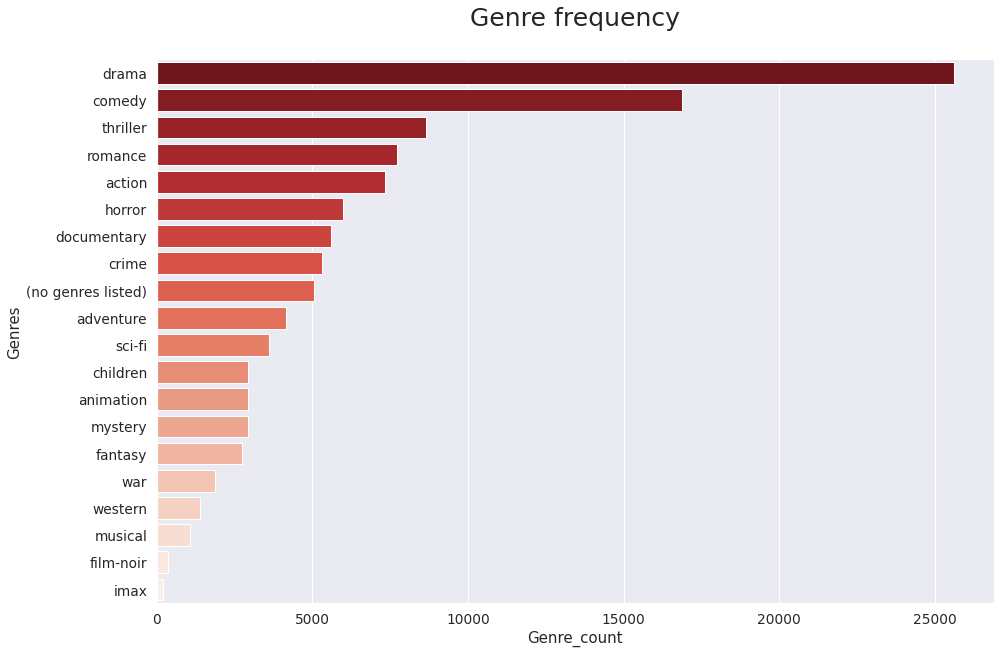

In [ ]:
def genre_count(input_df):
    """
    This function takes in the movies dataframe and cleans the genre column 
    before extracting the unique genres together with their respective
    frequencies in the dataset.
    
    This information is then used to create a bar graph
    showing how frequently each genre occurs in the dataset
    
    Input: input df
           datatype: DataFrame
           
    Output: None
    
    """   
    df = input_df.copy()
    dict_count = {}
    
    # Extract the unique genres
    all_genres = set(','.join([genres.replace('|',',').lower() for genres in df.genres]).split(','))
    
    # Log the frequency of each genre 
    for genre in all_genres:
        dict_count[genre] = ','.join([genres.replace('|',',').lower() for genres in df.genres]).count(genre)
        
    # Sort the genres according to their frequency
    sorted_dict = sorted(dict_count.items(), key=lambda x: x[1],reverse=True)
    genre, frequency = zip(*sorted_dict)
    
    # Create bar plot 
    fig = plt.figure(4, figsize=(15,10))
    sns.barplot(x=frequency, y=list(genre), palette='Reds_r')
    plt.title('Genre frequency\n',fontsize=25)
    plt.xlabel('Genre_count', fontsize=15)
    plt.ylabel('Genres', fontsize=15)
    
    plt.show()
    
    return

genre_count(movies)


**Observations:**
* There are 19 unique genres 
* 5062 films have no genre listed which accounts for 5% of the films in the dataset
* Majority of the films fall into the drama, comedy and thriller genres.
* Dramas account for 23% 
* Comedies makes up 15% of the films
* 8% of the films fall into the thriller genre
* The Imax genre accounts for the smallest portion of the films in the dataset at less than 1% since this is a relatively new genre and the dataset goes back 50 years

<a id="subsection-four"></a>
## Trends in genre popularity

The following figure shows the number of ratings movies from each genre have received over the last 50 years.

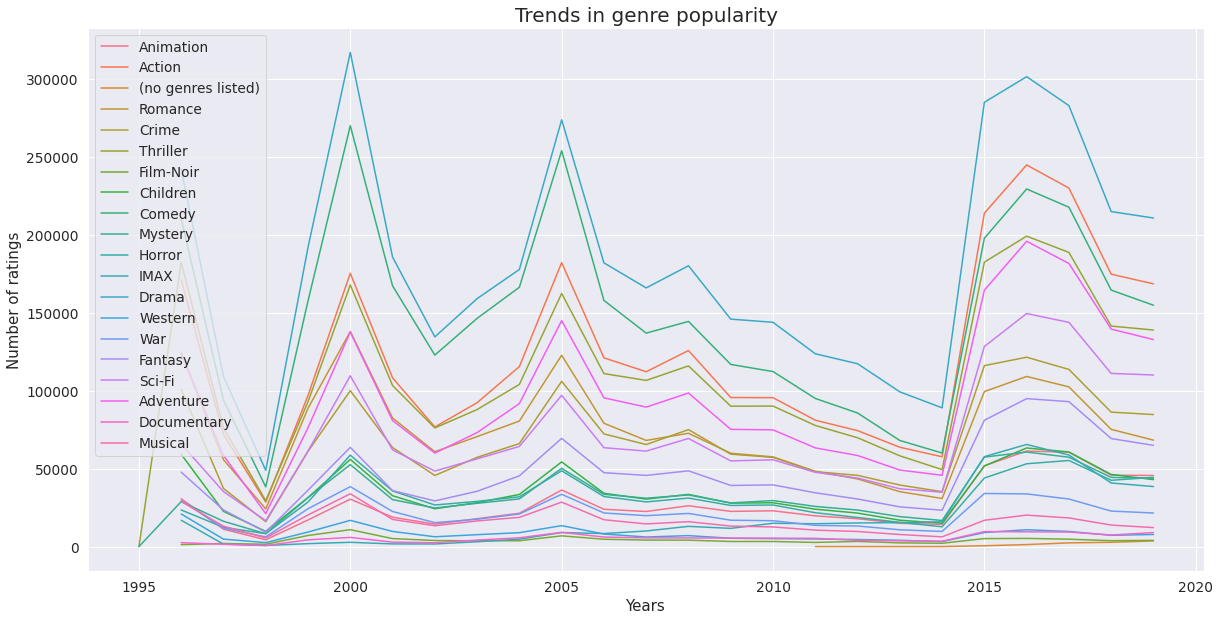

In [ ]:
def most_watched(input_df):  
    """"
    This function creates a plot showing the popularity of each genre 
    over the last 50 years.
    
    Input: input_df
           datatype: DataFrame
           
    Output: None
    
    """   
    # Create a copy of the input dataframe and merge it to the movies dataframe
    df = input_df.copy()
    df = df.merge(movies,on='movieId',how='left')
    
    # Create an empty dataframe
    b = pd.DataFrame()
    
    # Extract the timestamps and genres 
    timestamps = [timestamp for timestamp in df.timestamp]
    all_genres = set(','.join([genres.replace('|',',') for genres in df.genres]).split(','))
    
    # Get the number of ratings for each genre for each year since 1970
    for index,genre in enumerate(all_genres):
        a = pd.Series([int((timestamps[i]/31536000)+1970) for i,x in enumerate(df.genres) if genre in x])
        a = a.value_counts()
        b = pd.concat([b,pd.DataFrame({genre:a})],axis=1)
    
    # Plot the trends for each genre on the same line graph 
    plt.figure(figsize=(20,10))
    plot = sns.lineplot(data=b, dashes=False)
      
    # Add plot labels
    plt.title('Trends in genre popularity',fontsize=20)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Number of ratings', fontsize=15)
    
    plt.show()
    
    return

most_watched(train)

**Observations:**
* we see a similar trend for most genres with a huge spike in 2015, this could be because of an increase in users and/or an increase in the number of movies released. 
* we also observe a sharp spike in 1996 in the number of movies rated in each genre followed by a huge dip in the following two years...Have to find the why. 
* It is also worth noting that the count of movie ratings has gone down across the boards in the last 5 years

<a id="subsection-five"></a>
## Plot keywords
Lets have a look at the most frequently occuring plot keywords in the movielens dataset

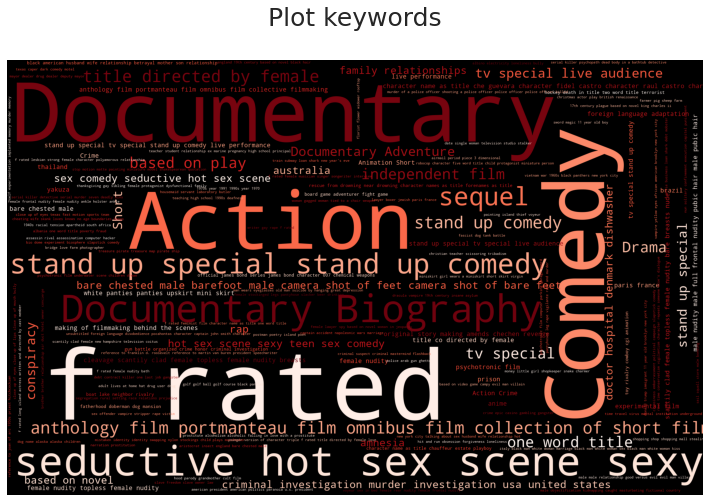

In [ ]:
def wordcloud_generator(df, column):  
    """
    This function extracts all the unique keywords in a column
    and counts the number of times each keyword occurs in the column
    while ignoring words that are not meaningful.
    these keywords are then used to generate a word cloud 
    
    Input: df
           datatype: DataFrame
           column
           datatype: str
           
    Output: wordcloud
            Datatype: None
            
    """    
    keyword_counts = {}
    keyword_pair = []
    words = dict()
    
    # list of words that should be ignored
    ignore = ['nan', ' nan', 'nan ', 'seefullsummary', ' seefullsummary', 'seefullsummary ']
    
    # Extract the unique keywords 
    for keyword in [keyword for keyword in df[column] if keyword not in ignore]:
        if keyword in keyword_counts.keys():
            keyword_counts[keyword] += 1
        else:
            keyword_counts[keyword] = 1
     
    # Pair the keywords with their frequencies
    for word,word_freq in keyword_counts.items():
        keyword_pair.append((word,word_freq))
       
    # Sort the keywords accprding to their frequencies
    keyword_pair.sort(key = lambda x: x[1],reverse=True)
    
    # Make it wordcloud-ready
    for s in keyword_pair:
        words[s[0]] = s[1]
        
    # Create a wordcloud using the top 2000 keywords
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          background_color='black', 
                          max_words=2000,
                          max_font_size=110,
                          scale=3,
                          random_state=0,
                          colormap='Reds').generate_from_frequencies(words)

    return wordcloud 

# Plot wordcloud
plot_keywords = wordcloud_generator(df, 'plot_keywords')
f = plt.figure(figsize=(20, 8)) 
plt.imshow(plot_keywords) 
plt.axis('off') 
plt.title('Plot keywords\n', fontsize=25)
plt.show()

**Observations:**
* Words that stand out occur more frequently in the dataset.
* One of the words that stands out is F-rated which is a feminist classification system designed to highlight films that are written, directed or starring women
* We see a few comedy related keywords like 'Comedy', 'stand up special', 'stand up comedy'
* Documentary, biography and conspiracy are popular keywords.
* Keywords like 'Seductive', 'hot', 'sexy', 'sex scene', ect are all over the wordcloud. This is because most films, regardless of the genre seem to have some element of sex appeal.

<a id="subsection-six"></a>
## Directors
A film director controls a film's artistic and dramatic aspects and visualizes the screenplay while guiding the technical crew and actors in the fulfilment of that vision. The director has a key role in choosing the cast members, production design and all the creative aspects of filmmaking.

Let's have a closer look at the directors that appear frequently in our dataset. They must be doing something right.

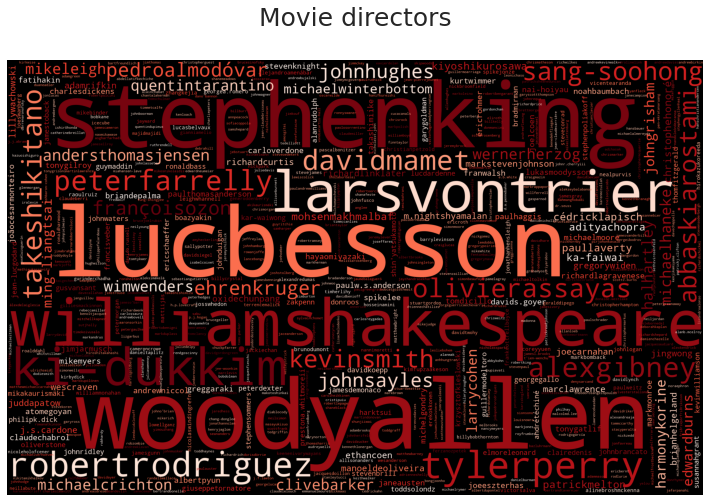

In [ ]:
# Generate a WordCloud using the movie directors  
directors = wordcloud_generator(df, 'director')

# Plot the WordCloud 
f = plt.figure(figsize=(20, 8)) 
plt.imshow(directors) 
plt.axis('off') 
plt.title('Movie directors\n', fontsize=25)
plt.show()

**Observations:**
* Our intuition was right, immediately we see some big names in the film industry jumping out at us
* Stephen King and Shakespeare? Well.. It's more likely that these films were based on their work 
* Woody Allen is an American director, writer, actor, and comedian whose career spans more than six decades and multiple Academy Award-winning movies
* Tyler Perry has directed some amazing films like Acrimony and the Madea films. He now has his own motion picture studio, 'Tyler Perry Studios'
* Luc Paul Maurice Besson is a French film director, screenwriter, and producer. He directed or produced the films Subway, The Big Blue, and La Femme Nikita. Besson is associated with the Cinéma du look film movement

<a id="subsection-seven"></a>
## Actors
I'm sure we all have certain actors we feel can do no wrong and we just love watching. The film cast will definitely have an influence on how much you enjoy or how highly you rate a movie. I for one love everything Taraji P. Henson touches.

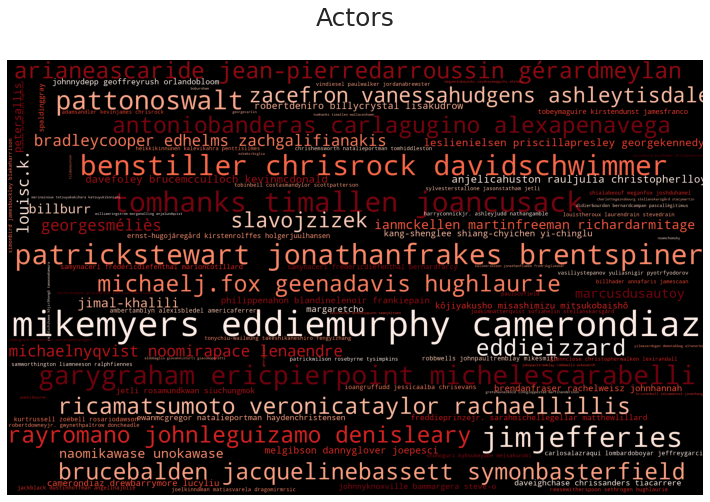

In [ ]:
# Generate a wordcloud using the 2000 most frequently occuring actors' names in the dataset
df['title_cast'] = df['title_cast'].apply(lambda x: " ".join(x))
actors = wordcloud_generator(df, 'title_cast')

# plot the WordCloud                        
f = plt.figure(figsize=(20, 8)) 
plt.imshow(actors) 
plt.axis('off') 
plt.title('Actors\n', fontsize=25)
plt.show()


**Observations:**
* Tom Hanks: An American actor and filmmaker. Known for both his comedic and dramatic roles, Hanks is one of the most popular and recognizable film stars worldwide, and is widely regarded as an American cultural icon. 

* Ben Stiller: Throughout his career he has written, starred in, directed, or produced more than 50 films including The Secret Life of Walter Mitty, Zoolander, The Cable Guy and There's Something About Mary.

* Eddie Murphy and Chris Rock are both successful comedians turned actors who have starred in numerous films throughout their careers

<a id="section-fours"></a>
# Memory handling
Before we move on to building our recommender system it's good practice (and in this case, very necessary) to free up some memory by deleting the variables/dataframes we're done using

In [ ]:
del top
del tags
del grouped
del ratings
del ratings_mean_count

<a id="section-five"></a>
# Building the reccomender system 

Recommender systems function with two kinds of information:

**Characteristic information.** This is information about items (keywords, categories, etc.) and users (preferences, profiles, etc.).

**User-item interactions.** This is information such as ratings, number of purchases, likes, etc.

Based on this, we can distinguish between three algorithms used in recommender systems:

* Content-based systems, which use characteristic information.

* Collaborative filtering systems, which are based on user-item interactions.

* Hybrid systems, which combine both types of information with the aim of avoiding problems that are generated when working with just one kind.

![1*rCK9VjrPgpHUvSNYw7qcuQ@2x.png](https://miro.medium.com/max/1000/1*rCK9VjrPgpHUvSNYw7qcuQ@2x.png)

<a id="subsection-1"></a>
## Content based filtering


**Idea: If you like an item then you will also like a “similar” item**

Content based recommender systems are based on the similarity of the items being recommended. It generally works well when its easy to determine the context/properties of each item. For instance when we are recommending the same kind of item like a movie recommendation or song recommendation.

In this recommender system the content of the movie (genre, keywords, cast, directors, tags, etc) will be used to find its similarity with other movies. The movies that are most likely to be similar are then recommended.

![Di8MPql.png?1](https://i.imgur.com/Di8MPql.png?1)



<a id="corpus"></a>
### Creating the corpus for each movie
We will be using the cast, director, plot keywords and genre as the metadata for our content based recommender system. These columns will be combined to form the corpus for each film which will then be used to determine the similarity between films.

In [ ]:
# Creating an empty column and list to store the corpus for each movie
df['corpus'] = ''
corpus = []

# List of the columns we want to use to create our corpus 
columns = ['title_cast', 'director', 'plot_keywords', 'genres']

# For each movie, combine the contents of the selected columns to form it's unique corpus 
for i in range(0, len(df['movieId'])):
    words = ''
    for col in columns:
        words = words + df.iloc[i][col] + " "        
    corpus.append(words)

# Add the corpus information for each movie to the dataframe 
df['corpus'] = corpus
df.set_index('movieId', inplace=True)

# Drop the columns we don't need anymore to preserve memory
df.drop(columns=['title_cast', 'director', 'plot_keywords', 'genres'], inplace=True)

df.head()

,title,corpus
movieId,,
1,Toy Story (1995),tomhanks timallen donrickles johnlasseter toy ...
2,Jumanji (1995),robinwilliams jonathanhyde kirstendunst jonath...
3,Grumpier Old Men (1995),waltermatthau jacklemmon sophialoren marksteve...
4,Waiting to Exhale (1995),whitneyhouston angelabassett lorettadevine ter...
5,Father of the Bride Part II (1995),stevemartin dianekeaton martinshort alberthack...


<a id="count"></a>
### Count matrix
Our corpus will be converted into a bag of words using the count vectorizer. 

The reason we chose to use the count vectorizer instead of tfidfvectorizer is because we don't want to penalize keywords, directors or actors that occur more frequently in the dataset. Having a high count across the dataset in this case does not mean that the word is less important. We also don't have any stopwords in the dataset that would need to be filtered out since we have already condensed our data.

In [ ]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df['corpus'])

<a id="sim"></a>
### Cosine similarity matrix

Similarity is calculated as the cosine of the angle between the 2 vectors of the item vectors of A and B. The closer the vectors, the smaller the angle and larger the cosine similarity.

![2b4a7a82-ad4c-4b2a-b808-e423a334de6f.png](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/assets/2b4a7a82-ad4c-4b2a-b808-e423a334de6f.png)

In [ ]:
cos_sim = cosine_similarity(count_matrix, count_matrix)
print(cos_sim.shape)
cos_sim

(24866, 24866)


array([[1.        , 0.20044593, 0.15811388, ..., 0.06681531, 0.        ,
        0.15075567],
       [0.20044593, 1.        , 0.        , ..., 0.14285714, 0.        ,
        0.16116459],
       [0.15811388, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06681531, 0.14285714, 0.        , ..., 1.        , 0.        ,
        0.0805823 ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.15075567, 0.16116459, 0.        , ..., 0.0805823 , 0.        ,
        1.        ]])

The resulting structure is a  24866 x 24866 dense similarity matrix  S , where the value of the entry in the  ith  row and  jth  column;  Si,j , corresponds to the similarity of movies  i  and  j  within our dataset.

Using this notation, if  i  and  j  are the same number (i.e. all the diagonal entries in  S ), then the similarity value is equal to 1 (an item is completely similar to itself).

<a id="top"></a>
### Top-N Recommendations
With our content similarity matrix computed, we're now ready to make some recommendations. We will begin by generating a top-N list of movies similar to one which we prompt the system with.

In [ ]:
def get_topN_recommendations(title, n=10):
    """
    This function gets the top n recomended movies based on the 
    title of the movie input by the user 
    
    Input: title
           Datatype: str
           
           n (default = 10)
           Datatype: int
    """ 
    # Create a a copy of the input dataframe where the index has been reset
    df1 = df.reset_index()
    
    # Extract the movie titles
    titles = df1['title']
    indices = pd.Series(df1.index, index=df['title'])
    idx = indices[title]
    
    # Get the similarity scores of the top n movies most similar to the user input
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n]
    
    # Exctract the titles of the top n most similar movies  
    movie_indices = [i[0] for i in sim_scores]
    
    return titles.iloc[movie_indices]

get_topN_recommendations('Ice Age (2002)').head(10)

10648           Ice Age 2: The Meltdown (2006)
18129      Ice Age 4: Continental Drift (2012)
13437    Ice Age: Dawn of the Dinosaurs (2009)
16662                   Winnie the Pooh (2011)
23854     A Flintstones Christmas Carol (1994)
151                      Batman Forever (1995)
9591             Pooh's Heffalump Movie (2005)
4873         Bill & Ted's Bogus Journey (1991)
7038                          Peter Pan (2003)
Name: title, dtype: object

**Observations and limitations:**
* The first 3 films in the top 10 recommended films for someone who enjoyed Ice Age are Sequels of the first Ice Age movie we watched.
* Although these movies are definitely very similar to the first Ice Age movie, I don't think the user will be too impressed with this list of recommendations
* A possible improvement for this content based recommendation system would be to filter out multiple sequels (maybe only keeping the most recent one)  
* We note that the majority of the recommended movies are animations
* The diversity of the recommendations is quite limited as content based recommender systems can't suggest anything too different from what the user has already seen.  
* The content based method is also extremely memory intensive, for this reason **we will not be using this method to make our predictions.** Instead we will focus on collaborative filtering.

<a id="subsection-2"></a>
## Collaborative Based Filtering

Collaborative methods for recommender systems are methods that are based solely on the past interactions recorded between users and items in order to produce new recommendations. These methods do not require item meta-data like their content-based counterparts. This makes them less memory intensive which is a major plus since our dataset is so huge.


### There are 2 collaborative based filtering methods:

#### memory based

We will investigate 2 two memory based methods: User-user and item-item. The main characteristics of user-user and item-item approaches is that they use only information from the user-item interaction matrix and they assume no model to produce new recommendations.

#### model based

Model based collaborative approaches only rely on user-item interactions information and assume a latent model supposed to explain these interactions. For example, matrix factorisation algorithms consists in decomposing the huge and sparse user-item interaction matrix into a product of two smaller and dense matrices: a user-factor matrix (containing users representations) that multiplies a factor-item matrix (containing items representations).

<a id="user"></a>
### User-user collaborative based filtering

This method captures the underlying pattern of interests of like-minded users and uses the choices and preferences of similar users to suggest new items.

In order to make a new recommendation to a user, the user-user method roughly tries to identify users with the most similar “interactions profile” (nearest neighbours) in order to suggest movies that are the most popular among these neighbours (and that are “new” to our user). This method is said to be “user-centred” as it represents users based on their interactions with items and evaluates distances between users.

![E1rCimk.jpg?1](https://i.imgur.com/E1rCimk.jpg?1)

In [ ]:
# Creating a small test dataframe to evaluate our models
tests = train.copy()
tests.drop(['timestamp'], axis=1, inplace=True)
tests = tests.head(10000)

# Creating the training data
reader = Reader(rating_scale=(0.5, 5))
test_data = Dataset.load_from_df(tests[['userId','movieId','rating']], reader)

# Compute similarities between users using cosine distance
sim_options = {"name": "cosine",
               "user_based": True}  

# Evaluate the model 
user = KNNWithMeans(sim_options=sim_options)
cv = cross_validate(user, test_data, cv=5, measures=['RMSE'], verbose=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1263  1.1231  1.1098  1.1202  1.0651  1.1089  0.0226  
Fit time          2.83    2.97    2.98    2.93    2.99    2.94    0.06    
Test time         0.03    0.03    0.03    0.03    0.03    0.03    0.00    


**Observations and limitations**
* Using UBCF gives us a RMSE score of 1.1 (based on a 1% sample of the train data)


* Even though user based collaborative based techniques are powerful, there are few challenges. Like other researchers, Sarwar et al. (2001) state that scalability and sparsity are the primary issues.

* **Scalability:** In a system where there are many new users, i.e. users with low records of ratings, it is computationally expensive to train the model. These problems arise with Nearest Neighbour algorithms in User based collaborative filtering where these algorithms require computations that grow simultaneously with the increasing numbers of users and items.

* **Data Sparsity:** Sparsity arises in a system when even the most active users have rated only a marginal number of available items. For example, these users may have experience with even less than 1% of available items making the correlation coefficient less reliable

* Another concern is that **user profiles change** quickly and the entire system model will have to be recomputed which is both time and computationally expensive

* If a recommender system experiences any of the described issues, the algorithm's performance decreases; i.e. the system does not recommend the user relevant items (Sarwar et al.,2001).

<a id="item"></a>
### Item-item collaborative based filtering

To tackle the issues with user-based collaborative based techniques, item-based collaborative techniques analyze the user-item matrix and identify relationships between different items (Sarwar et al.,2001). The item-based recommendation system then makes recommendations based on the discovered linear relationships (similarities) amongst the items. This method is more stable compared to user based collaborative filtering because the average item has a lot more ratings than the average user. So an individual rating doesn’t impact as much.

The idea of item-item method is to find movies similar to the ones the user already “positively” interacted with. Two items are considered to be similar if most of the users that have interacted with both of them did it in a similar way. This method is said to be “item-centred” as it represents items based on interactions users had with them and evaluates distances between those items.

![YghliZS.png?2](https://i.imgur.com/YghliZS.png?2)


In [ ]:
# Compute similarities between items using cosine distance
sim_options = {"name": "cosine",
               "user_based": False}  

# Fit the KNNwithmeans algorithm to the training set
item_based = KNNWithMeans(sim_options=sim_options)

# Evaluate the model 
cv = cross_validate(item_based, test_data, cv=5, measures=['RMSE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0612  1.1124  1.0631  1.0930  1.1113  1.0882  0.0224  
Fit time          0.53    0.55    0.53    0.57    0.55    0.55    0.02    
Test time         0.03    0.03    0.03    0.03    0.03    0.03    0.00    


**Observations and limitations:**

* Using IBCF gives us a RMSE score of 1.09 (based on a 1% sample of the train data) which is only a slight improvement on the UBCF method

<a id="svd"></a>
### Singular value decomposition (SVD)

Unlike Memory-Based Approaches, Model-Based procedures facilitate machine learning techniques such as Singular Value Decomposition (SVD) and Matrix Factorization models to predict the end user's rating on unrated items. 

We will be using SVD to build our recommender engine. We utilize the results of singular value decomposition (SVD) to fill the vacant ratings and then use the item based method to produce the prediction of unrated items.

Formally, SVD is decomposition of a matrix R which is the utility matrix with m equal to the number of users and m number exposed items (movies) into the product of three matrices:

* U is a left singular orthogonal matrix, representing the relationship between users and latent factors (Hopcroft & Kannan, 2012)

* Σ is a diagonal matrix (with positive real values) describing the strength of each latent factor

* V(transpose) is a right singular orthogonal matrix, indicating the similarity between items and latent factors.

![2020/02/svd2.png](https://www.dataminingapps.com/wp-content/uploads/2020/02/svd2.png)

The general goal of SVD (and other matrix factorization methods) is to decompose the matrix R with all missing values and multiply its components, U, Σ and V once again. As a result, there are no missing values and it is possible to recommend each user movies (items) they have not seen yet.


In [ ]:
# Evaluate the model 
svd = SVD(random_state=0)
cv = cross_validate(svd, test_data, cv=5, measures=['RMSE'], verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0544  1.0298  1.0259  1.0689  1.0345  1.0427  0.0163  
Fit time          1.03    1.03    1.02    1.02    1.01    1.02    0.01    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


* Using SVD gives us a RMSE score of 1.05 (based on a 1% sample of the train data) which is promising and the best of the 3 we've tested. We will go ahead and train this model using the entire dataset. 

<a id="section-six"></a>
# Submission

In [ ]:
# Train the model on the entire dataset 
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(train[['userId','movieId','rating']], reader)
trainingSet = data.build_full_trainset()
svd.fit(trainingSet)

# Make predictions using the trained model
pred = [svd.predict(test.userId[i],test.movieId[i]).est for i in test.index]
test['rating'] = pred

In [ ]:
# Create the csv file for submission
test['Id'] = test['userId'].astype(str)+'_'+test['movieId'].astype(str)
test = test[['Id','rating']]
test.to_csv('svd_submission.csv', index=False)

In [ ]:
test.head()

<a id="section-seven"></a>
# Conclusion

The 1M movieLens dataset was used to build our recommender system. This dataset contains movie ratings and movie specific data dating back 50 years. After doing an exploratory data analysis we noted that there was a huge spike in movie production between 1990 and 2000 which has slowed down significantly in the last few years. The most popular movie of the past 50 years is the Shawshank redemption starring Morgan Freeman which receives an average rating of 4.4 stars after being rated by more than 30000 users. There are 19 unique movie genres in the dataset with Drama, comedy and thriller being the 3 most popular genres.

We explored 4 different methods for building our recommender system.
The content based method proved to be too memory intensive and was dismissed as a possible solution. 

Collaborative based methods were investigated next since they are based solely on the past interactions recorded between users and items in order to produce new recommendations. These methods do not require item meta-data like their content-based counterparts.

The 2 memory based methods explored were user based and item based. Both these methods performed adequately but have issues with sparsity and scalability.

The final method we tried was singular value decomposition(SVD), a model based collaborative filtering method which addresses the sparsity issue we had with the user-user and item-item based methods as well as having the added benefit of being less memory intensive compared to content based filtering methods. 

The SVD model was able to predict new ratings with a RMSE of 0.8

### Possible improvements:

Collaborative filtering methods have the drawback of having a cold start problem, this can be addressed by creating a hybrid recommender system that uses a combination of content and collaborative filtering based methods.

![porky-pig-bugs-bunny-desktop-looney-tunes-animated-cartoon-goodbye-png-clip-art.png](https://w0.pngwave.com/png/1014/397/porky-pig-bugs-bunny-desktop-looney-tunes-animated-cartoon-goodbye-png-clip-art.png)

<a id="section-eight"></a>
# References

* Baptiste Rocca (2019). Introduction to recommender systems. [online] Medium. Available at: https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada. [Accessed 18 Jul. 2020].

* Tomar, A. (2019). ITEM-ITEM Collaborative filtering Recommender System in Python. [online] Medium. Available at: https://medium.com/@tomar.ankur287/item-item-collaborative-filtering-recommender-system-in-python-cf3c945fae1e [Accessed 18 Jul. 2020].

* Keller, J. (2019). Item-Item Recommendation with Surprise. [online] Medium. Available at: https://medium.com/@jmcneilkeller/item-item-recommendation-with-surprise-4bf365355d96 [Accessed 18 Jul. 2020].

* ai-pool.com. (n.d.). Recommendation Systems by Matrix Factorization and Collaborative Filtering. [online] Available at: https://ai-pool.com/a/s/recommendation-systems-by-matrix-factorization-and-collaborative-filtering [Accessed 18 Jul. 2020].

* Kumar, D.V. (2020). Singular Value Decomposition (SVD) In Recommender System. [online] Analytics India Magazine. Available at: https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/ [Accessed 18 Jul. 2020].

* Maher Malaeb (2016). Singular Value decomposition (SVD) in recommender systems for Non-math-statistics-programming…. [online] Medium. Available at: https://medium.com/@m_n_malaeb/singular-value-decomposition-svd-in-recommender-systems-for-non-math-statistics-programming-4a622de653e9. [Accessed 15 Jul. 2020]

* Bhattacharyya, M. (2020). Beginner’s Guide to Creating an SVD Recommender System. [online] Medium. Available at: https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65 [Accessed 15 Jul. 2020].

* matplotlib.org. (n.d.). matplotlib.pyplot.colors — Matplotlib 2.2.3 documentation. [online] Available at: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.colors.html [Accessed 13 Jul. 2020].

* www.quora.com. (n.d.). Recommendation Systems: What is the difference between item-to-item collaborative filtering and content-based filtering? - Quora. [online] Available at: https://www.quora.com/Recommendation-Systems-What-is-the-difference-between-item-to-item-collaborative-filtering-and-content-based-filtering [Accessed 13 Jul. 2020].

* Analytics Vidhya. (2016). Building Recommendation Engine In Python | R. [online] Available at: https://www.analyticsvidhya.com/blog/2016/06/quick-guide-build-recommendation-engine-python/ [Accessed 13 Jul. 2020].

* mc.ai. (2019). Deep Learning for Collaborative Filtering (using FastAI). [online] Available at: https://mc.ai/deep-learning-for-collaborative-filtering-using-fastai/ [Accessed 13 Jul. 2020].

* Lungu, C. (2018). Building a recommender system. [online] Machine Learning Blog. Available at: http://www.clungu.com/Building-a-recommender-system/ [Accessed 13 Jul. 2020].